In [1]:
import copy
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid
from scipy.interpolate import RectBivariateSpline
from scipy.special import legendre

import SSLimPy.interface.sslimpy as sslimpy
from SSLimPy.LIMsurvey import Covariance, PowerSpectra

In [2]:
envkey = 'OMP_NUM_THREADS'
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
os.environ[envkey] = str(7)

In [3]:
cosmodict={"h":0.67,"Omegam":0.32,"Omegab":0.04,"As":2.1e-9, "mnu":0.06}
settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : True,
            "Smooth_window" : True,
            }
Asslimpy = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict)

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#


In [4]:
pobs = PowerSpectra.PowerSpectra(Asslimpy.fiducialcosmo,Asslimpy.fiducialastro)

Text(0, 0.5, '$ k^3 \\|W_\\mathrm{survey}\\|^2 [\\mathrm{Mpc}^{3}] $')

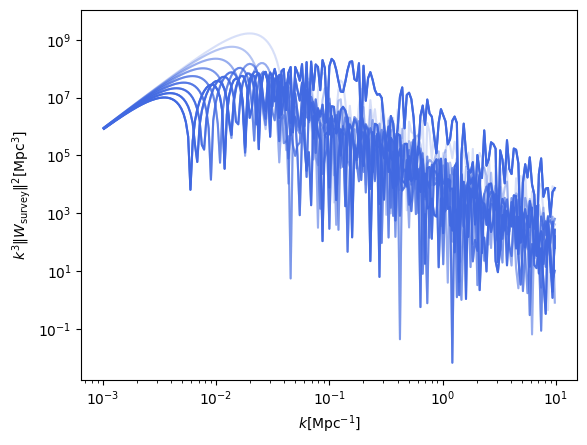

In [17]:
q = pobs.k
mu = pobs.mu
W, Vs = pobs.Wsurvey(q,mu)

index = np.array(range(19))
for i in index:
    plt.loglog(q,q**3*np.abs(W[:,i*7,0])**2, c="RoyalBlue", alpha=np.abs(mu[i*7]))
plt.xlabel(r"$ k [\mathrm{Mpc}^{-1}] $")
plt.ylabel(r"$ k^3 \|W_\mathrm{survey}\|^2 [\mathrm{Mpc}^{3}] $")


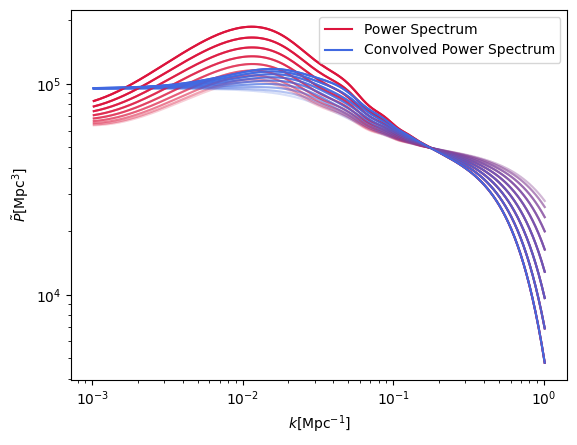

In [13]:
Pk = pobs.Pk_true
Pconv = pobs.Pk_Obs

for i in index:
    plt.loglog(q[:150],Pk[:150,i*7,0], c="crimson", alpha=np.abs(mu[i*7]))
    plt.loglog(q[:150],Pconv[:150,i*7,0], c="RoyalBlue", alpha=np.abs(mu[i*7]))
plt.xlabel(r"$ k [\mathrm{Mpc}^{-1}] $")
plt.ylabel(r"$ \tilde{P} [\mathrm{Mpc}^{3}] $")
plt.plot([],[],c="crimson", label="Power Spectrum")
plt.plot([],[],c="royalblue", label="Convolved Power Spectrum")
plt.legend()

In [18]:
monopole_conv = trapezoid(Pconv[:,:,0],mu)
monopole_theory = trapezoid(Pk[:,:,0],mu)
qua_conv = trapezoid(legendre(2)(mu)*Pconv[:,:,0],mu)
qua_theory = trapezoid(legendre(2)(mu)*Pk[:,:,0],mu)

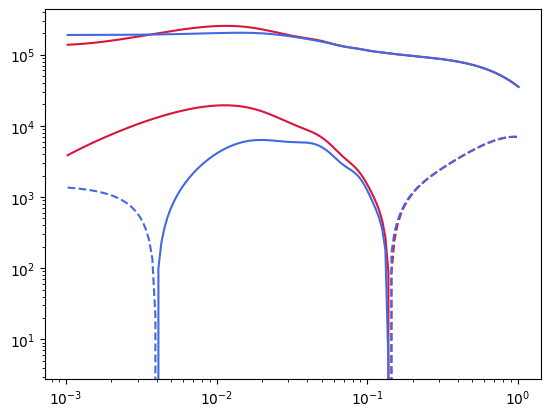

In [19]:

plt.loglog(q[:150], monopole_theory[:150],c="crimson")
plt.loglog(q[:150], qua_theory[:150],c="crimson")
plt.loglog(q[:150], -qua_theory[:150],c="crimson",ls="--")


plt.loglog(q[:150], monopole_conv[:150],c="RoyalBlue")
plt.loglog(q[:150], qua_conv[:150],c="RoyalBlue")
plt.loglog(q[:150], -qua_conv[:150],c="RoyalBlue",ls="--")


In [20]:
Vs

array([31056162.97681928])

In [21]:
import SSLimPy.interface.config as cfg
nu = pobs.nu
nuObs = pobs.nuObs
Delta_nu = cfg.obspars["Delta_nu"]
z = (nu / nuObs - 1).to(1).value
z_min = (nu / (nuObs + Delta_nu / 2) - 1).to(1).value
z_max = (nu / (nuObs - Delta_nu / 2) - 1).to(1).value

In [22]:
Sfield = pobs.Sfield(z, cfg.obspars["Omega_field"])
Lperp = np.sqrt(Sfield / np.pi)
Lparr = pobs.Lfield(z_min, z_max)

In [23]:
(Lparr * Sfield) / Vs

<Quantity [0.94142891] Mpc3>

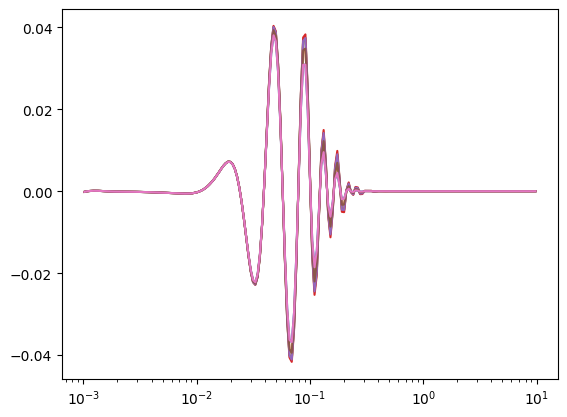

In [25]:
k = pobs.k
mu = np.linspace(-1,1,7)
Pk_dw_grid = pobs.dewiggled_pdd(pobs.k,mu,pobs.z)
Pk_nw_grid = Asslimpy.fiducialcosmo.nonwiggle_pow(pobs.k,pobs.z)[:,None]
test_1 = Pk_dw_grid/Pk_nw_grid-1
inter_over = RectBivariateSpline(np.log(k.value),mu,test_1)
plt.plot(k,inter_over(np.log(k.value),mu))
plt.xscale("log")

In [24]:
Asslimpy.fiducialastro.CLT(pobs.z)

<Quantity [0.00104043] Mpc3 uK / solLum>

In [25]:
print(Asslimpy.fiducialastro.Tmoments(pobs.z))
print(Asslimpy.fiducialastro.Tmoments(pobs.z,moment=2))

[1.49946184] uK
[895.78840942] Mpc3 uK2
